In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# Helper Functions

In [2]:
def show_image(img):
    plt.figure(figsize=(5,5));
    plt.imshow(img, cmap="gray");
    plt.axis("off");

In [3]:
def get_stats(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    ds_np = np.array(batch[0], dtype = np.float64)
    mean = np.mean(ds_np, dtype=np.float64)
    cov = np.cov(ds_np.reshape(ds_np.shape[1],ds_np.shape[0]))
    var = ds_np.var(axis=0, dtype=np.float64)
    return mean, cov, var

In [16]:
def get_noisy_batch(batch, cov):
    noisy_samples = []
    for i in range(batch.shape[0]):
        xt = batch[i,...]
        noisy_dist = torch.distributions.multivariate_normal.MultivariateNormal(xt, cov)
        noisy_samples.append(noisy_dist.sample())
    return torch.stack(noisy_samples)

In [17]:
def get_ori_ds(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    return batch[0]

# Dataset

In [4]:
train_tfms = T.Compose([
    T.RandomCrop((28,28)),
    T.Grayscale(),
    T.ToTensor(),
    T.Lambda(lambda x: x.view(x.shape[1]**2)) # reshaping for our input shape
])

In [5]:
ds = torchvision.datasets.CIFAR10(root = "../data/", 
                                  train = True, 
                                  transform  = train_tfms, 
                                  target_transform = None, 
                                  download = False)

In [6]:
ori_loader = DataLoader(ds,
                        batch_size=2,
                        num_workers=4,
                        shuffle=True,
                        pin_memory=True)

In [7]:
mean, cov, var = get_stats(ds)

In [8]:
def whitening_ds(ds, covariance_matrix, mean, epsilon=1e-5):
    mean = torch.from_numpy(np.array(mean))
    U,S,V = np.linalg.svd(covariance_matrix)
    zca = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    return (torch.from_numpy(zca).double() @ (ds.T - mean).double()).permute(1,0)

In [9]:
def get_ds_whitened(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    whitened_ds = whitening_ds(batch[0], cov, mean, epsilon=1e-5)

    return whitened_ds

In [10]:
whitened_ds = get_ds_whitened(ds)

# cNCE Loss Function

In [11]:
def cnce_loss(xt, yt):
    """ Computes the cNCE loss function:
    inputs:
        - precision matrix
    """
    def cmpt_g(xt, yt):
        log_phi_xt = model(xt)
        log_phi_yt = model(yt)
        st = torch.stack((log_phi_xt, log_phi_yt), dim = 1)
        return log_phi_xt, st

    log_phi_xt, st = cmpt_g(xt, yt)
    loss = log_phi_xt - torch.logsumexp(st, dim = 1)
    loss = loss.mean()
    return  -loss

### Covar for the Noisy Dist

In [12]:
covariance_noise = torch.from_numpy(np.diag(var / 100))

# DEM 

In [49]:
class DeepEBM(torch.nn.Module):
    def __init__(self, std, k, normalizer = torch.tensor(-1000.0, dtype = torch.float64)):
        super(DeepEBM,self).__init__()
        self.std = std
        self.in_feat = 784
        self.out_feat = k
        self.V = torch.nn.Parameter(torch.empty((self.out_feat, self.in_feat), dtype = torch.float64))
        self.W = torch.nn.Parameter(torch.empty((self.out_feat, self.out_feat), dtype = torch.float64))
        self.b = torch.nn.Parameter(torch.empty((self.in_feat, 1), dtype = torch.float64))
        self.c = torch.nn.Parameter(torch.empty((self.out_feat, 1), dtype = torch.float64))
        self.S = torch.nn.Softplus()
        self.s = torch.nn.Sigmoid()
        self.normalizer = torch.nn.Parameter(normalizer)
        torch.nn.init.normal_(self.V, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.W, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.b, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.c, mean =0.0, std=0.01)

        
    def forward(self,x):
        g_theta_x = self.s(self.V @ x.permute(1,0))
        a = torch.sum(self.S(self.W.T @ g_theta_x + self.c), dim = 0).reshape(1, -1)
        b_ = self.b.T @ x.permute(1,0)
        c_ = (- 0.5 * (1 / self.std**2) * torch.norm(x, dim = 1)**2).reshape(1, -1)
        log_ptheta = c_ + b_ + a
        return (-log_ptheta + self.normalizer)

In [50]:
model = DeepEBM(1.0, 64)

# Optimizer Initialization

In [51]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

# Training

In [52]:
whitenings_ds = True

In [53]:
if whitenings_ds:
    ori_ds = whitened_ds
else:
    ori_ds = get_ori_ds(ds)

In [54]:
batch_size = 1000

In [55]:
epochs = 3

In [56]:
for epoch in range(epochs):
    total_loss = 0
    for i in range(int(ori_ds.shape[0]/batch_size)):
        optim.zero_grad()

        batch = ori_ds[i*batch_size:(i+1)*batch_size,...]
        batch = batch.double()
        noisy_batch = get_noisy_batch(batch, covariance_noise)
        loss = cnce_loss(batch, noisy_batch)

        loss.backward()
        print(f"Epoch {epoch}/It.{i}   Loss:{loss.detach().item()}")
        total_loss += loss.detach().item()
        optim.step()
    print(f"Avg: Epoch {epoch}   Loss:{total_loss/(ori_ds.shape[0]/batch_size)}")

Epoch 0/It.0   Loss:0.8671841112584313
Epoch 0/It.1   Loss:0.8914405313405696
Epoch 0/It.2   Loss:0.8911427308895259
Epoch 0/It.3   Loss:0.8847036980572982
Epoch 0/It.4   Loss:0.8855179660935193
Epoch 0/It.5   Loss:0.9044312230380885
Epoch 0/It.6   Loss:0.8988646523441817
Epoch 0/It.7   Loss:0.8754905691811433
Epoch 0/It.8   Loss:0.8899266328460621
Epoch 0/It.9   Loss:0.8973387266523944
Epoch 0/It.10   Loss:0.8944559508527611
Epoch 0/It.11   Loss:0.8821540069873148
Epoch 0/It.12   Loss:0.9047311292898044
Epoch 0/It.13   Loss:0.9170387389280616
Epoch 0/It.14   Loss:0.8777728876527117
Epoch 0/It.15   Loss:0.8931990659779963
Epoch 0/It.16   Loss:0.8749860517901522
Epoch 0/It.17   Loss:0.8815042017700087
Epoch 0/It.18   Loss:0.8804065051823304
Epoch 0/It.19   Loss:0.8695729495992316
Epoch 0/It.20   Loss:0.8936958321241677
Epoch 0/It.21   Loss:0.9117839184273105
Epoch 0/It.22   Loss:0.8922057520304709
Epoch 0/It.23   Loss:0.9196530730566685
Epoch 0/It.24   Loss:0.8993915649655067
Epoch 0/It

# Results

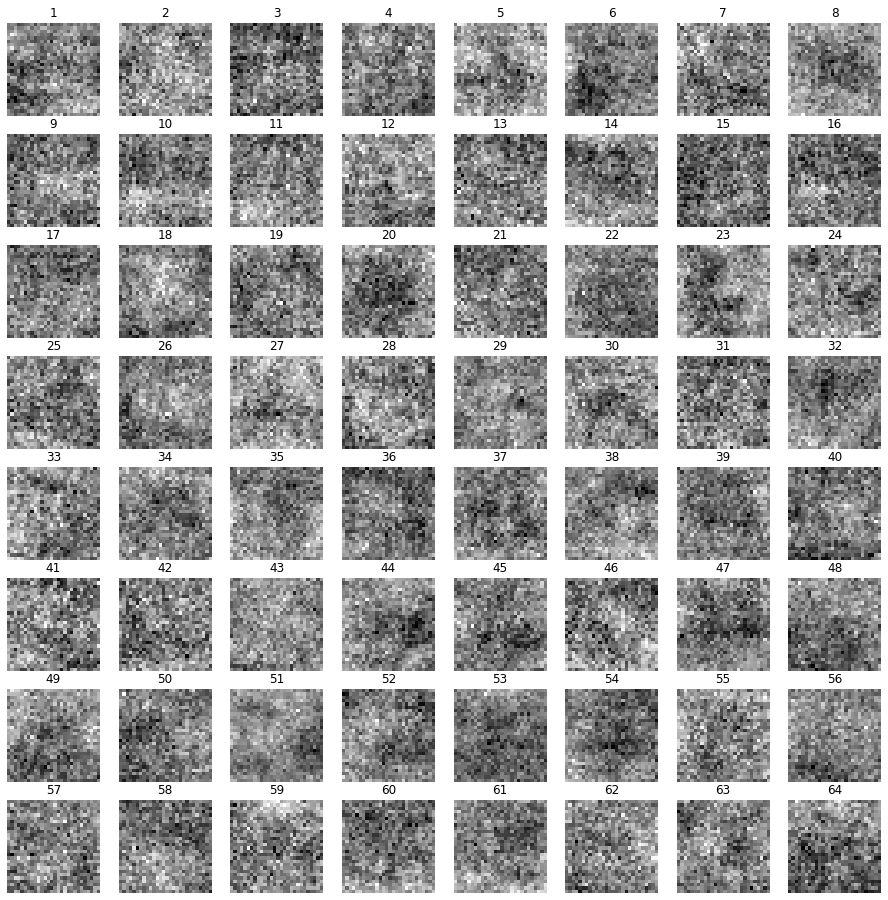

In [57]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()

for i in range(64):

    axs[i].imshow(model.V.detach().numpy()[i,...].reshape(28,28), cmap ="gray")
    axs[i].axis("off");
    axs[i].set_title(str(i+1))